In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Import for Tensorflow Quant Finance
import os, sys
# sys.path.append(r'c:\\Users\\owen.tam\\Documents\\owen\\projects\\tf-quant-finance')

import tf_quant_finance as tff 
 
# Shortcut alias
pde = tff.math.pde
option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol


### Price ETH option with closed form solution
Can do multiple options by extending the arrays.

In [35]:
forwards = np.array([3000])
strikes = np.array([3200])
expiries = np.array([0.5])
volatilities = np.array([0.85])
discount_factors = 1
is_call_options = np.array([True])

out_prices = option_price(
      volatilities=volatilities,
      strikes=strikes/forwards,
      expiries=expiries,
      forwards=forwards/forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options).numpy() * forwards

prices = np.array([630])

out_ivs = implied_vol(
    prices=prices/forwards,
    strikes=strikes/forwards,
    expiries=expiries,
    forwards=forwards/forwards,
    validate_args=False,
    tolerance=1e-8,
    max_iterations=1000).numpy()

out_prices, out_ivs

(array([636.37155871]), array([0.8423321]))

In [81]:
# RestClient
"""
    This module implements the FtxClient class and enables interaction with the FTX exchange.
"""

import time
import urllib.parse
from typing import Optional, Dict, Any

import hmac
import json
import requests

class RestClient:
    def __init__(self, api_url, api_key=None, api_secret=None, subaccount_name=None) -> None:
        self.API_URL = api_url
        self._api_key = api_key
        self._api_secret = api_secret
        self._subaccount_name = subaccount_name

    def _get(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('GET', path, params=params)

    def _post(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('POST', path, payload=params)

    def _delete(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('DELETE', path, payload=params)

    def _request(self, method: str, endpoint: str, auth: bool = True, params={}, payload={}, api=None):
        for count in range(1,4):
            try:
                _payload = json.dumps(payload) if payload else ''
                _endpoint=f'{endpoint}?{urllib.parse.urlencode(params, safe="/")}' if params else _endpoint
                if not api:
                    api = self.API_URL

                url = f'{api}{_endpoint}'

                header = {}
                if method == 'GET':
                    response = requests.get(url, headers=header, timeout=3)
                elif method == 'POST':
                    response = requests.post(url, data=_payload, headers=header, timeout=3)
                elif method == 'DELETE':
                    response = requests.delete(url, data=_payload, headers=header, timeout=3)

                data = response.json()
                response.close()
                return data
            except ConnectionError as err:
                time.sleep(0.5*count)
            except Exception as err:
                time.sleep(0.5*count)

    def _generate_signature(self, timestamp: str, method: str, endpoint: str, data='') -> dict:
        message = f'{timestamp}{method}{endpoint}{data}'
        signature = hmac.new(self._api_secret.encode('utf-8'), message.encode('utf-8'), 'sha256').hexdigest()
        return signature

    def get_endpoint(self, endpoint, params={}):
        return self._get(endpoint, params)

    def post_endpoint(self, endpoint, params={}):
        return self._post(endpoint, params)

client = RestClient("https://defi-bot.bastioncb.com:1443/")


In [160]:
def discount_factor_fn1(t):
  return tf.math.exp(0 * 1 * tf.convert_to_tensor(t, dtype=tf.DType))

discount_factor_fn = discount_factor_fn1
discount_factor_fn(0.1) 

TypeError: Cannot convert the argument `type_value`: <class 'tensorflow.python.framework.dtypes.DType'> to a TensorFlow DType.

In [129]:
# 1. Feed Volatility surface using a processed_market_data.VolatilitySurface instance
from tf_quant_finance.experimental.pricing_platform.framework.market_data.volatility_surface import VolatilitySurface
spot = 31600

# Construct tff native Datetensors
import datetime
valuation_date = tff.datetime.dates_from_datetimes([datetime.date(2022, 6, 1)])
dates = [datetime.date(2022, 6, 2) + datetime.timedelta(days=i) for i in range(30*6+15)]
expiries = tff.datetime.dates_from_datetimes(dates)

# Construct the strike space
dk = 1000
strikes = np.array([10000 + dk*i for i in range(40000//dk)])

# Obtain IVs from volsurface
date_strings = ",".join([date.strftime('%d%b%y').upper() for date in dates])
strikes_strings = ",".join([str(strike) for strike in strikes])
params =  {"symbols": "BTC", 
           "maturities": date_strings, 
           "strikes": strikes_strings}

# dict: { maturity: {price: iv, ... }, ... }
response = client.get_endpoint('volsurface', params)

# Parse Volsurface and prepare input format
# 2D 
input_vols = np.empty((expiries.shape[0], strikes.shape[0]))

for i, maturity in enumerate(list(response.keys())):
  for j, price in enumerate(response[maturity]):
    input_vols[i,j] = response[maturity][price]
    
# Test that it returns the right surface
volsurface = VolatilitySurface(valuation_date, expiries, strikes, input_vols)

print(volsurface.volatility(strike=np.array([32100]), 
                            expiry_dates=tff.datetime.dates_from_datetimes([datetime.date(2022, 7, 1)])).numpy())
  
from tf_quant_finance.experimental.local_volatility import LocalVolatilityModel

LocalVolatilityModel.from_volatility_surface(
  dim = 1,
  spot = np.array([spot]),
  implied_volatility_surface = volsurface,
  discount_factor_fn = lambda t: tf.math.exp(0 * t)
)

[0.6283411]


TypeError: Cannot convert the argument `type_value`: None to a TensorFlow DType.

1. Feed Volatility surface using a processed_market_data.VolatilitySurface instance
2. Initialise it in pricing_platform\framework\market_data\volatility_surface.py -> VolatilitySurface()
3. Initialise LocalVolatilityModel.from_volatility_surface()
4. Feed LocalVolatilityModel.local_volatility_fn()


In [ ]:

# Parse Volsurface and prepare input format
# inpt_strikes = []
# inpt_expiries = []
# inpt_vols = []
cp_vols = np.empty((expiries.shape[0], strikes.shape[0]))

for i, maturity in enumerate(list(response.keys())):
  for j, price in enumerate(response[maturity]):
    # inpt_strikes.append(float(price))
    # inpt_expiries.append(datetime.datetime.strptime(maturity, '%d%b%y').date())
    # inpt_vols.append(response[maturity][price])
    cp_vols[i,j] = response[maturity][price]
    
# inpt_strikes = np.array(inpt_strikes)
# inpt_expiries = tff.datetime.dates_from_datetimes(inpt_expiries)
# inpt_vols = np.array(inpt_vols)

# Test that it returns the right surface

### MC pricing of a vanilla option with custom vol and drift model

In [36]:
#@title Set up parameters

dtype = np.float64 #@param
num_samples = 10**6 #@param

num_timesteps = 100 #@param

expiries = [0.5] # This can be a rank 1 Tensor
dt = 1. / num_timesteps
rate = tf.constant(0, dtype=dtype)
sigma = tf.constant(0.85, dtype=dtype)
spot = tf.constant(3000, dtype=dtype)

strikes = tf.constant([3200], dtype=dtype)

def set_up_pricer(expiries, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        
        # Can modify to include a different vol model
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        
        log_spot = tf.math.log(tf.reduce_mean(spot))
        
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
            
        paths = process.sample_paths(
            expiries, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        
        prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        
        return prices
      
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(expiries))

price_eu_options(strikes, spot, sigma).numpy()

array([[636.32154772]])

### Integrate local vol model into the MC solver 

 ### American Option pricer using the PDE solver
   American option price $V(x, t)$ of an option with spot price $x$ at time $t$
   under Black-Scholes model satisfies the following PDE
   $$V_{t} + \frac{\sigma^2}{2}  x^2  V_{xx} + r  x  V_{x}
 - r  V(t, x) = 0.$$
  Tensorflow Quant Finance library provides tools for solving Parabolic PDE's
  of the form  
  $$V_{t} + \frac{a(t, x)}{2}  V_{xx} + b(t, x) V_{x} - c(t, x)  V = 0$$

  Henceforth,
  $a(t, x)$, $b(t, x)$, and $c(t, x)$ are referred to as quadratic, linear and
  shift coefficients, respectively. We describe in details how to write a
  custom pricer that is both batchable (i.e., multiple equations can be solved
  simultaneously) and compatible with an NVIDIA GPU. 


In [ ]:

# tf.function decorator makes the function faster in graph mode.
@tf.function
def my_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=tf.float64):
  # Define the coordinate grid
  s_min = 0.01
  s_max = 999999.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [risk_free_rate * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    values_floor = tf.nn.relu(s - strike)
    return grid, tf.maximum(values, values_floor)

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]

def option_param(number_of_options, dtype, seed=42):
  """ Function to generate volatilities, rates, strikes """
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
      np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
      np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.8], dtype)
    risk_free_rate = tf.constant([0.0], dtype)
    strike = tf.constant([30000], dtype)
  return volatility, risk_free_rate, strike

In [34]:

# tf.function decorator makes the function faster in graph mode.
@tf.function
def american_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=tf.float64):
  """ Computes American Call options prices.

  Args:
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `(number_of_options, number_grid_points)` and the corresponding `Tensor` 
    of grid locations of shape `(number_grid_points,)`.
  """
  # Define the coordinate grid
  s_min = 0.01
  s_max = 999999.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [risk_free_rate * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    values_floor = tf.nn.relu(s - strike)
    return grid, tf.maximum(values, values_floor)

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]

def option_param(number_of_options, dtype, seed=42):
  """ Function to generate volatilities, rates, strikes """
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
      np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
      np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.8], dtype)
    risk_free_rate = tf.constant([0.0], dtype)
    strike = tf.constant([30000], dtype)
  return volatility, risk_free_rate, strike

### Batching

* Batching is a powerful feature of design of Tensorflow.
* TFF leverages this strongly.
* Most methods can accept a "batch" of inputs.
* Example below (Batch of American Call Options with varying strikes, vols and rates).



In [35]:
#@title Price multiple American Call options at a time

number_of_options = 1 #@param

time_delta = 0.005

expiry = 1.0  

number_grid_points = 1024 

dtype = tf.float64 

# spot = 110  + tf.random.uniform(shape=[number_of_options, 1], dtype=dtype)

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

# Build a graph to compute prices of the American Options.
estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=expiry,
    number_grid_points=number_grid_points,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    strike=strike,
    dtype=dtype)

# Convert to numpy for plotting
estimate = estimate.numpy()
grid_locations = grid_locations.numpy()

<function outer_factory.<locals>.inner_factory.<locals>.tf__dirichlet.<locals>.fn at 0x000001DE1B1EA9D0>
0


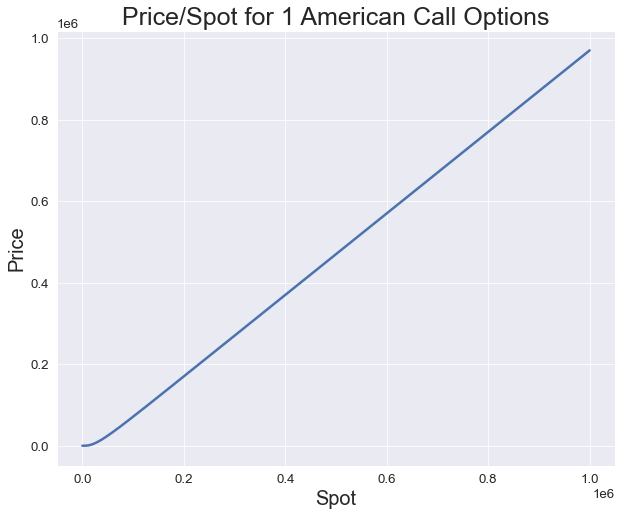

In [45]:
#@title Price/spot plot for the American Call options
# Prepare data for plotting 
options = [x + 1 for x in range(number_of_options) for _ in range(1024)]
plot_data = pd.DataFrame({
    'Spot': list(np.ndarray.flatten(grid_locations)) * number_of_options, 
    'Price': estimate.flatten(),
    'Option': options})


# Plot
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plot = sns.lineplot(x="Spot", y="Price", hue="Option",
                    data=plot_data,
                    palette=sns.color_palette()[:number_of_options],
                    legend=False)
plot.axes.set_title(f"Price/Spot for {number_of_options} American Call Options",
                    fontsize=25)
xlabel = plot.axes.get_xlabel()
ylabel = plot.axes.get_ylabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

### GPU Implementation

In [7]:
#@title Tensorflow Finance pricing on GPU

number_of_options = 10000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/gpu:0"
with tf.device(device):
  
  # Warmup (graph construction + graph optimization)
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_gpu = time.time() - t
    
gpu_options_per_second = number_of_options / time_gpu
print('------------------------')
print('Tensorflow GPU')
print('wall time: ', time_gpu)
print('options per second: ', gpu_options_per_second)
print('------------------------')

NameError: name 'option_param' is not defined